In [1]:
import os
from functools import partial
import numpy as np
import scipy.sparse as sp
from typing import Tuple, Union
from numpy.typing import ArrayLike
#import cupy as cp
#import cupy.sparse as scp
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as la
import scipy.sparse as sp
import scipy.sparse.linalg as sla
from tqdm.notebook import tqdm
import kwant

from colorsys import hls_to_rgb

def colorize(z):
    n, m = z.shape
    c = np.zeros((n, m, 3))
    c[np.isinf(z)] = (1.0, 1.0, 1.0)
    c[np.isnan(z)] = (0.5, 0.5, 0.5)

    idx = ~(np.isinf(z) + np.isnan(z))
    phase = (np.angle(z[idx]) + np.pi) / (2 * np.pi)
    phase = (phase + 0.5) % 1.0
    amplitude = 1.0 - 1.0 / (1.0 + abs(z[idx])**0.3)
    color = [hls_to_rgb(p, a, 0.8) for p, a in zip(phase, amplitude)]
    c[idx] = color
    return c

In [2]:
# Pauli matrices
s0 = np.array([[1.0, 0.0], [0.0, 1.0]], dtype=complex)
sx = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=complex)
sy = np.array([[0.0, -1j], [1j, 0.0]], dtype=complex)
sz = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=complex)

# Kronecker products
t0s0 = np.kron(s0, s0)
t0sx = np.kron(s0, sx)
t0sy = np.kron(s0, sy)
t0sz = np.kron(s0, sz)

txs0 = np.kron(sx, s0)
txsx = np.kron(sx, sx)
txsy = np.kron(sx, sy)
txsz = np.kron(sx, sz)

tys0 = np.kron(sy, s0)
tysx = np.kron(sy, sx)
tysy = np.kron(sy, sy)
tysz = np.kron(sy, sz)

tzs0 = np.kron(sz, s0)
tzsx = np.kron(sz, sx)
tzsy = np.kron(sz, sy)
tzsz = np.kron(sz, sz)

In [3]:
def generate_grid_and_operators(Nx: int, Ny: int) -> Tuple[ArrayLike, ArrayLike, ArrayLike, sp.csr_matrix, sp.csr_matrix, sp.csr_matrix, sp.csr_matrix]:
    """
    Generate grids, differential operators, and Laplacian operators for a tight-binding simulation.

    Parameters:
        Nx (int): Number of points along the x-axis.
        Ny (int): Number of points along the y-axis.

    Returns:
        Tuple[ArrayLike, ArrayLike, ArrayLike, sp.csr_matrix, sp.csr_matrix, sp.csr_matrix, sp.csr_matrix]:
            - x (ArrayLike): 2D array representing the x-coordinates grid.
            - y (ArrayLike): 2D array representing the y-coordinates grid.
            - r (ArrayLike): 2D array representing the radial distance from the origin.
            - theta (ArrayLike): 2D array representing the polar angle.
            - Dx (scipy.sparse.csr_matrix): x-axis differential operator.
            - Dy (scipy.sparse.csr_matrix): y-axis differential operator.
            - Lx (scipy.sparse.csr_matrix): Laplacian operator along the x-axis.
            - Ly (scipy.sparse.csr_matrix): Laplacian operator along the y-axis.
    """
    x_ax = np.linspace(-(Nx//2), Nx//2, Nx)
    y_ax = np.linspace(-(Ny//2),  Ny//2, Ny)
    x, y = np.meshgrid(x_ax, y_ax)
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    # Calculate x and y differential operators
    _Dx = sp.diags([+1*np.ones(Nx-1), -1*np.ones(Nx-1)], [+1, -1], format='csr') / 2
    Dx = sp.kron(sp.eye(Ny), _Dx)

    _Dy = sp.diags([+1*np.ones(Ny-1), -1*np.ones(Ny-1)], [+1, -1]) / 2
    Dy = sp.kron(_Dy, sp.eye(Nx))

    # Calculate x and y Laplacian operators
    _Lx = sp.diags([+1*np.ones(Nx-1), -2*np.ones(Nx), +1*np.ones(Nx-1)], [+1, 0, -1], format='csr')
    Lx = sp.kron(sp.eye(Ny), _Lx)

    _Ly = sp.diags([+1*np.ones(Ny-1), -2*np.ones(Ny), +1*np.ones(Ny-1)], [+1, 0, -1], format='csr')
    Ly = sp.kron(_Ly, sp.eye(Nx))

    return x, y, r, theta, Dx, Dy, Lx, Ly

In [5]:
def generate_hamiltonian(Nx: int, Ny: int, t: float, t_am: float, mu: float) -> sp.csr_matrix:
    """
    Generate the Hamiltonian for a tight-binding simulation.

    Parameters:
        Nx (int): Number of points along the x-axis.
        Ny (int): Number of points along the y-axis.
        t (float): Hopping parameter for the kinetic energy part.
        t_am (float): Hopping parameter for the antiferromagnet part.
        mu (float): Chemical potential.
        Delta (ArrayLike): Superconducting order parameter as a function of position.
        phi (ArrayLike): Phase of the superconducting order parameter.

    Returns:
        sp.csr_matrix: The Hamiltonian matrix.

    """
    x, y, r, theta, Dx, Dy, Lx, Ly = generate_grid_and_operators(Nx, Ny)

    Delta = (1 - np.exp(-r/5))
    phi = theta
    # Kinetic energy part
    H_n = -t * (Ly + Lx)
    H_n += -mu * sp.eye(Nx * Ny)

    # Superconductor
    H_s = (sp.kron(sp.diags(Delta.flatten() * np.cos(theta).flatten()), txs0) + 
           sp.kron(sp.diags(Delta.flatten() * np.sin(theta).flatten()), -tys0))

    # Antiferromagnet
    H_m = -t_am * (Ly - Lx)

    # Create the full Hamiltonian
    H = sp.kron(H_n, tzs0) + sp.kron(H_m, t0sz) + H_s   

    return H

In [6]:
def generate_hamiltonian2(Nx, Ny, t, t_am, mu):
    # Create a Kwant system
    lat = kwant.lattice.square(a=1, norbs=4)
    syst = kwant.Builder()

    
    def circle(pos):
        (x, y) = pos
        r = x ** 2 + y ** 2
        return r < (51 ** 2)
    
    def square(pos):
        (x, y) = pos
        return (abs(x)<101)*(abs(y)<101)
    
    def onsite(site1):
        (x, y) = site1.pos
        return ((mu + 4 * t) * tzs0
                  + (1 - np.exp(-np.sqrt(x**2+y**2)/5)) * np.cos(np.arctan2(y, x)) * (+txs0)
                  + (1 - np.exp(-np.sqrt(x**2+y**2)/5)) * np.sin(np.arctan2(y, x)) * (-tys0))

    def hopx(site1, site2):
        return -t * tzs0 + t_am * t0sz
    
    def hopy(site1, site2):
        return -t * tzs0 - t_am * t0sz
    
    syst[lat.shape(circle, (0, 0))] = onsite
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = hopx
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = hopy
    
    hamiltonian = syst.finalized().hamiltonian_submatrix(sparse=True)
    return hamiltonian

In [7]:
Nx = 201
Ny = 201
t = 10
t_am = 0.1
mu = 0#2 * t

H1 = generate_hamiltonian(Nx, Ny, t, t_am, mu)
H2 = generate_hamiltonian2(Nx, Ny, t, t_am, mu)

In [ ]:
H1.tocsc()[:4, :4].toarray().real

In [86]:
H2.tocsc()[:4, :4].toarray().real

array([[ 40.        ,   0.        ,  -0.98054416,   0.        ],
       [  0.        ,  40.        ,   0.        ,  -0.98054416],
       [ -0.98054416,   0.        , -40.        ,   0.        ],
       [  0.        ,  -0.98054416,   0.        , -40.        ]])

In [31]:
import numpy as np
import pylab as plt

# Plot the array "A" using colorize
plt.imshow(colorize(Delta*np.exp(1j*phi)), interpolation='none', extent=(-5, 5, -5, 5))
plt.title('Complex Function')
plt.colorbar(label='Amplitude')
plt.show()

NameError: name 'Delta' is not defined

In [135]:
# #w, v = la.eigh(H)

# H_gpu = cp.asarray(H)
# w_gpu, v_gpu = cp.linalg.eigh(H_gpu)
# w = cp.asnumpy(w_gpu)
# v = cp.asnumpy(v_gpu)

In [136]:
k = 10
ws, vs = sla.eigsh(H, k=k, sigma=0)

In [137]:
sort_idxs = np.argsort(ws)
ws=ws[sort_idxs]
vs=vs[:, sort_idxs]

In [138]:
ws

array([-0.1454561 , -0.08873183, -0.08873183, -0.0298711 , -0.0298711 ,
        0.0298711 ,  0.0298711 ,  0.08873183,  0.08873183,  0.1454561 ])

In [139]:
idx = np.argmin(abs(ws))
v = vs[:, idx]
v_r = v.reshape(Ny, Nx, 4, order='C')

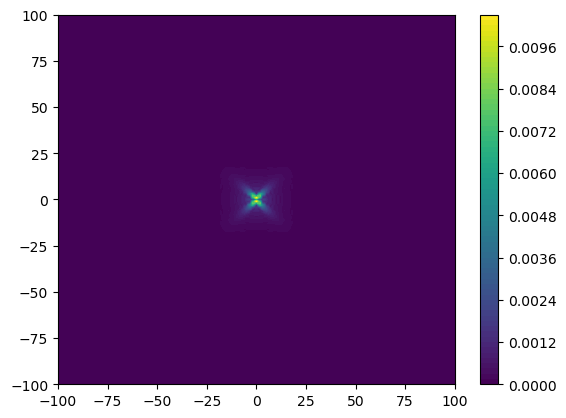

In [140]:
fig, ax = plt.subplots()
im = ax.contourf(x, y, (np.abs(v_r[:])**2).sum(axis=-1), levels=100)
#plt.contour(x, y, np.abs(Delta)**2, levels=5, colors='w')
fig.colorbar(im)

In [141]:
H.shape

(161604, 161604)

In [ ]:
J_op = i (H.conj().T M - M H)

In [98]:
plt.contourf(x, y, (np.abs(v_r[..., (Ny*Nx*4)//2+1])**2).sum(axis=-1), levels=100)
plt.contour(x, y, np.abs(Delta)**2, levels=5, colors='w')
plt.colorbar()

IndexError: index 5203 is out of bounds for axis 2 with size 4

In [99]:
v0 = v[..., (Ny*Nx*4)//2]
v0_r = v0.reshape(Ny*Nx, 4)

ValueError: cannot reshape array of size 1 into shape (2601,4)

In [100]:
J_x = np.einsum("is, ij, js -> is", v_r.conj(), Dx, v0_r)
J_y = np.einsum("is, ij, js -> is", v_r.conj(), Dy, v0_r)

J_n_x = np.einsum("ij -> i", J_x)
J_n_y = np.einsum("ij -> i", J_y)

NameError: name 'v0_r' is not defined

In [97]:
plt.quiver(x, y, J_n_x.reshape(Ny, Nx), J_n_y.reshape(Ny, Nx))

NameError: name 'J_n_x' is not defined

In [ ]:
J_x

In [8]:
    x, y, r, theta, Dx, Dy, Lx, Ly = generate_grid_and_operators(Nx, Ny)


In [15]:
(Dx@Dx).tocsc()[:8, :8].toarray()

array([[-0.25,  0.  ,  0.25,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.5 ,  0.  ,  0.25,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.25,  0.  , -0.5 ,  0.  ,  0.25,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.25,  0.  , -0.5 ,  0.  ,  0.25,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.25,  0.  , -0.5 ,  0.  ,  0.25,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.25,  0.  , -0.5 ,  0.  ,  0.25],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.25,  0.  , -0.5 ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.25,  0.  , -0.5 ]])